In [1]:
import copy
import os
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import scipy

from yass.evaluate.stability import *
from yass.evaluate.util import *
from yass.geometry import parse, find_channel_neighbors
from yass.deconvolute.ind_run import run

from deconv_exp_utils import *
from match_pursuit import MatchPursuit

from tqdm import tqdm
#import mpld3

from deconv_exp_utils import vis_chan, recon

%matplotlib inline

/home/hooshmand/Documents/github/yassenv/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load Data and Gold Standard Spike Traing

In [24]:
base_dir = '/ssd/data/peter/ej49_dataset'

raw = os.path.join(base_dir, 'ej49_data1_set1.bin')
geom = os.path.join(base_dir, 'ej49_geometry1.txt')
st_file = os.path.join(base_dir, 'groundtruth_ej49_data1_set1.mat')

rbi = RecordingBatchIterator(
    rec_file=raw, n_chan=49, batch_time_samples=2000000,
    geom_file=geom, n_batches=3, radius=70, sample_rate=20000,
    whiten=False)

# Real Or Synthetic Dataset

By setting `REAL` to `True` the algorithm will run on real dataset. Otherwise, we synthesize data.

In [27]:
REAL = True
# Lenght of recording in time samples.
TOT_TIME = int(20000 * 10)
T = TOT_TIME

if REAL:
    rbi.reset_cursor()
    data = rbi.next_batch()
data = data[:T, :]
print data.shape

(200000, 49)


# Compute Mean Wave Form

Set `LOAD` variable to `True` if the waveforms have been computed and the results are saved locally.

In [28]:
# Set to False if it is the first time runing
LOAD = True

temp_file = 'gold_temp.npy'
align_temp_file = 'align_gold_temp.npy'
gold_sp_file = 'gold_sp.npy'

if not LOAD:
    gold_sp = sio.loadmat(st_file)
    gold_sp = np.append(gold_sp['spt_gt'], gold_sp['L_gt'])
    gold_sp = gold_sp.reshape([2, len(gold_sp) // 2]).T

    mwc = MeanWaveCalculator(batch_reader=rbi, spike_train=gold_sp, window=range(-20, 30))
    mwc.compute_templates(6)
    mwc_temps = mwc.templates
    np.save(temp_file, mwc_temps)
    np.save(gold_sp_file, gold_sp)

    # align templates or not
    align_temps = []
    n_unit = mwc_temps.shape[2]
    for unit in tqdm(range(n_unit)):
        t, _ = optimal_aligned_compress(mwc_temps[:, :, unit])
        align_temps.append(t.T)
    align_temps = np.array(align_temps).T
    align_temps = scipy.signal.resample(align_temps, int(align_temps.shape[0] / 5.))
    np.save(align_temp_file, align_temps)

else:
    gold_sp = np.load(gold_sp_file)
    mwc_temps = np.load(temp_file)
    align_temps = np.load(align_temp_file)

# Use Subset of Cells Only (Skip if Real Data Used)

If you would like to use only a subset of the gold standard units
to create synthetic data set variables `SUBSET` and `only_units` accordintly.

In [4]:
SUBSET = False
only_units = [5, 10, 35]

if SUBSET:
    spt_idx = gold_sp[:, 1] == only_units[0]
    for i in range(1, len(only_units)):
        spt_idx = np.logical_or(spt_idx, gold_sp[:, 1] == only_units[i])
    gold_sp = gold_sp[spt_idx, :]

    cid = 0
    for unit in only_units:
        gold_sp[gold_sp[:, 1] == unit, 1] = cid
        cid += 1
    mwc_temps = mwc_temps[:, :, only_units]

In [5]:
VIS = False
if VIS:
    fig, ax = plt.subplots(7, 7)
    for i in range(49):
        ax[i // 7, i % 7].plot(mwc_temps[:, :, i])
    fig.set_size_inches(40, 40)

In [6]:
gold_sp

array([[      7,      39],
       [     13,      26],
       [     51,      28],
       ...,
       [5999929,      45],
       [5999931,      33],
       [5999991,       7]], dtype=int32)

# Set Parameters for Synthetic Data (Skip if Real Data Used)

In [38]:
# Rank of SVD decomposition of approximating
# Convolution operation.
RANK = 3
# Whether to use aligned version of templates.
ALIGN = False
# Whether to add noise to the data set or not.
NOISE = True

data = fake_data(spt=gold_sp, temps=mwc_temps, length=T, noise=NOISE)

# Visualize the First Temporal Chunk of the Recording

Text(0.5,1,u'Temporal chunk of recording')

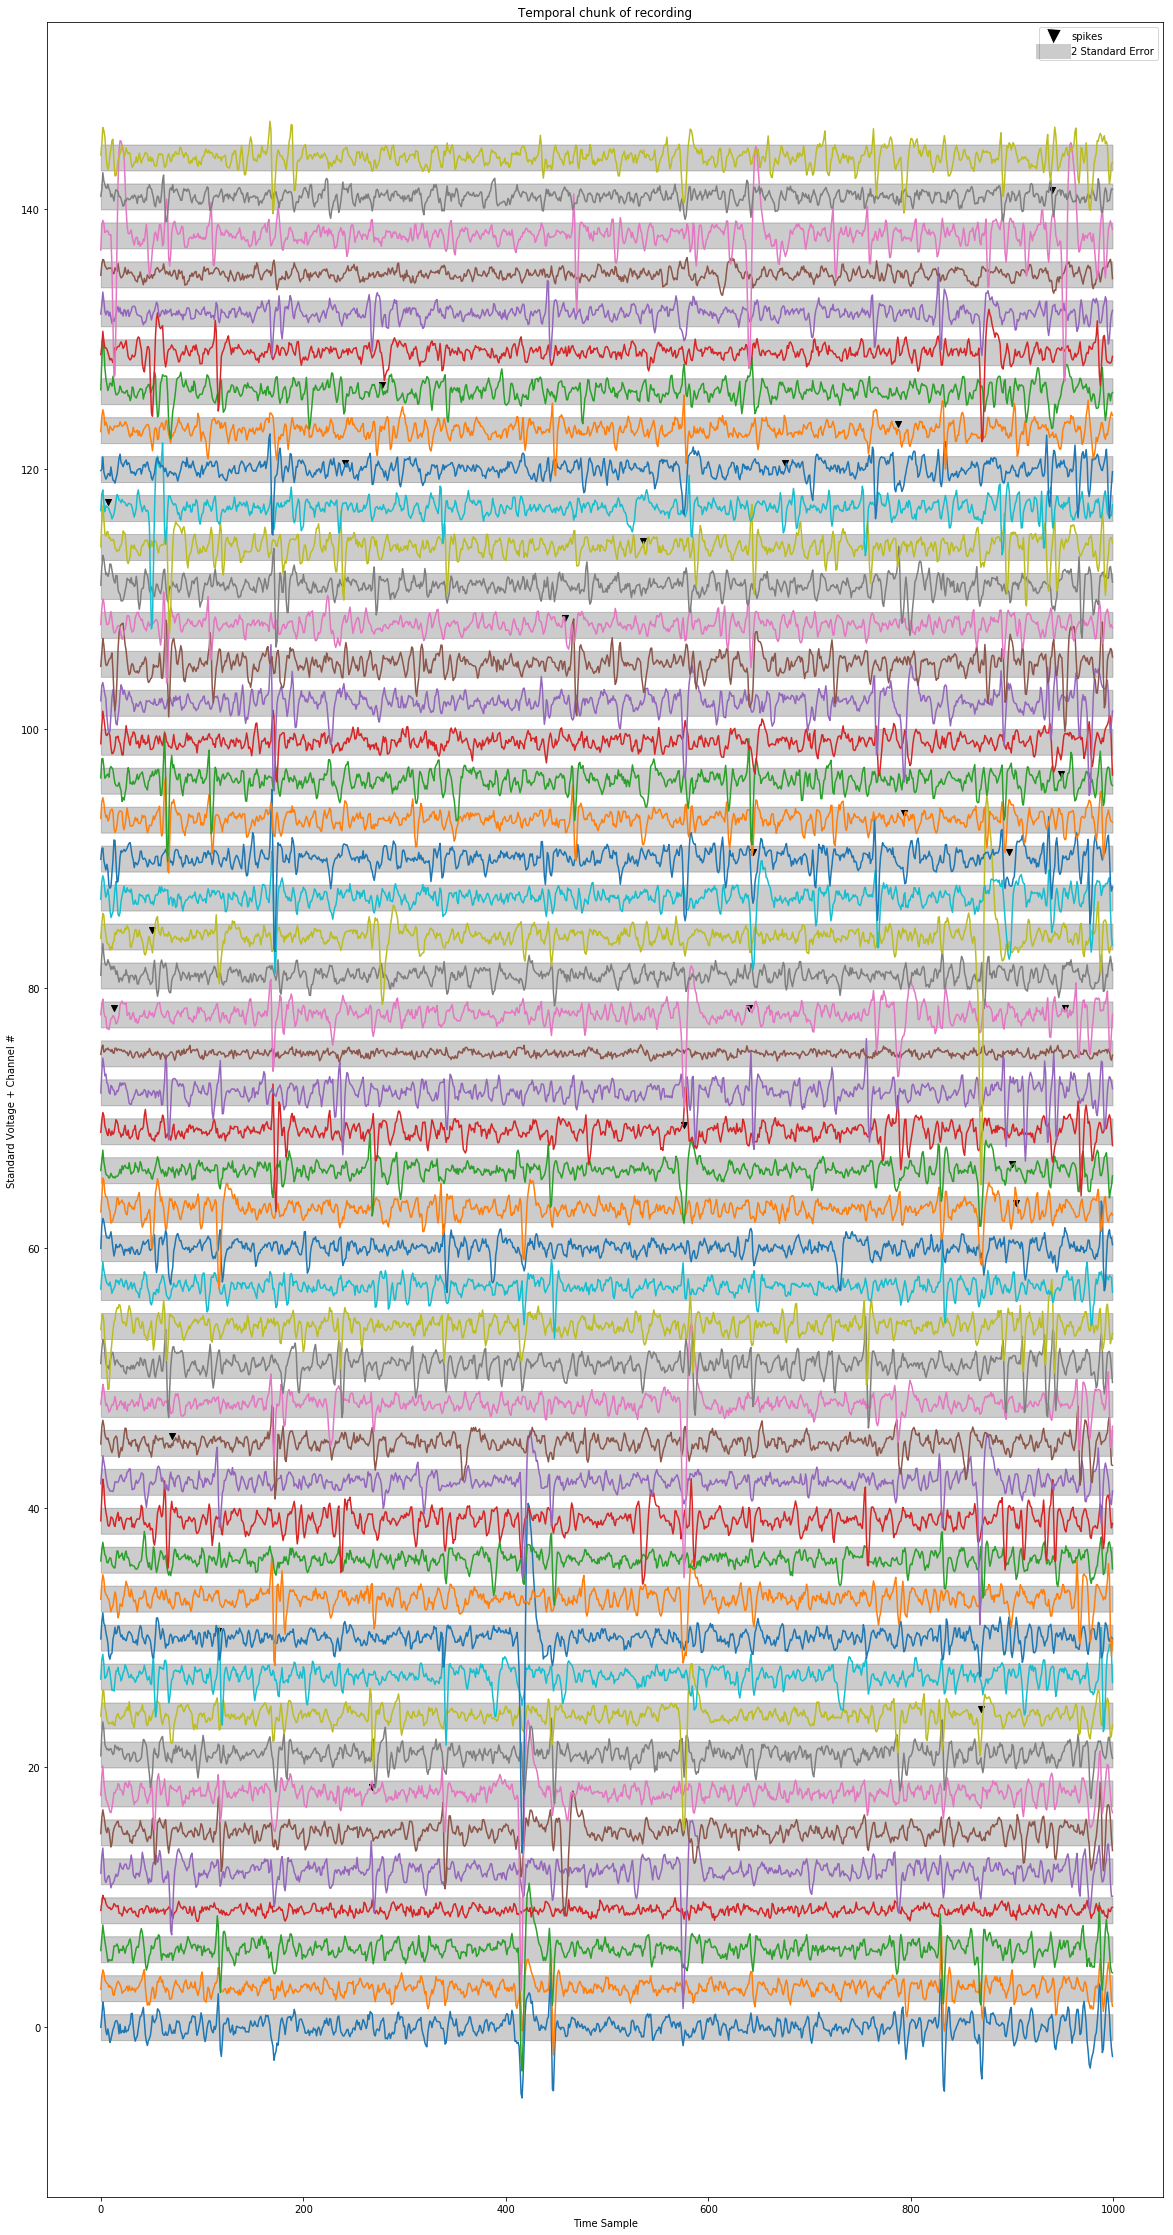

In [29]:
trunc_to = 1000
gold_sp_trunc = gold_sp[gold_sp[:, 0] < trunc_to, :]

fig, ax = plt.subplots()
for c in range(49):
    unit_sp = gold_sp_trunc[gold_sp_trunc[:, 1] == c, 0]
    offset = 3 * c
    ax.scatter(unit_sp, np.zeros(len(unit_sp)) + offset + 0.5, color='0', marker='v')
    ax.plot(data[:trunc_to, c] + offset)
    ax.fill_between(
        range(trunc_to),
        np.zeros(trunc_to) + offset + 1,
        np.zeros(trunc_to) + offset - 1, color='0', alpha=0.2)

legend_elements = [Line2D([0], [0], marker='v', color='w', label='spikes',
                          markerfacecolor='0', markersize=15),
                   Line2D([0], [0], lw=15, color='0', alpha=0.2, label='2 Standard Error')]
ax.legend(handles=legend_elements)

fig.set_size_inches(20, 40)
ax.set_xlabel("Time Sample")
ax.set_ylabel("Standard Voltage + Channel #")
ax.set_title("Temporal chunk of recording")

In [30]:
data1 = copy.copy(data)
mp = MatchPursuit(data1, mwc_temps, threshold=2, obj_energy=False)

# Let's visualize a Temporal Cunk of the Objective Matrix

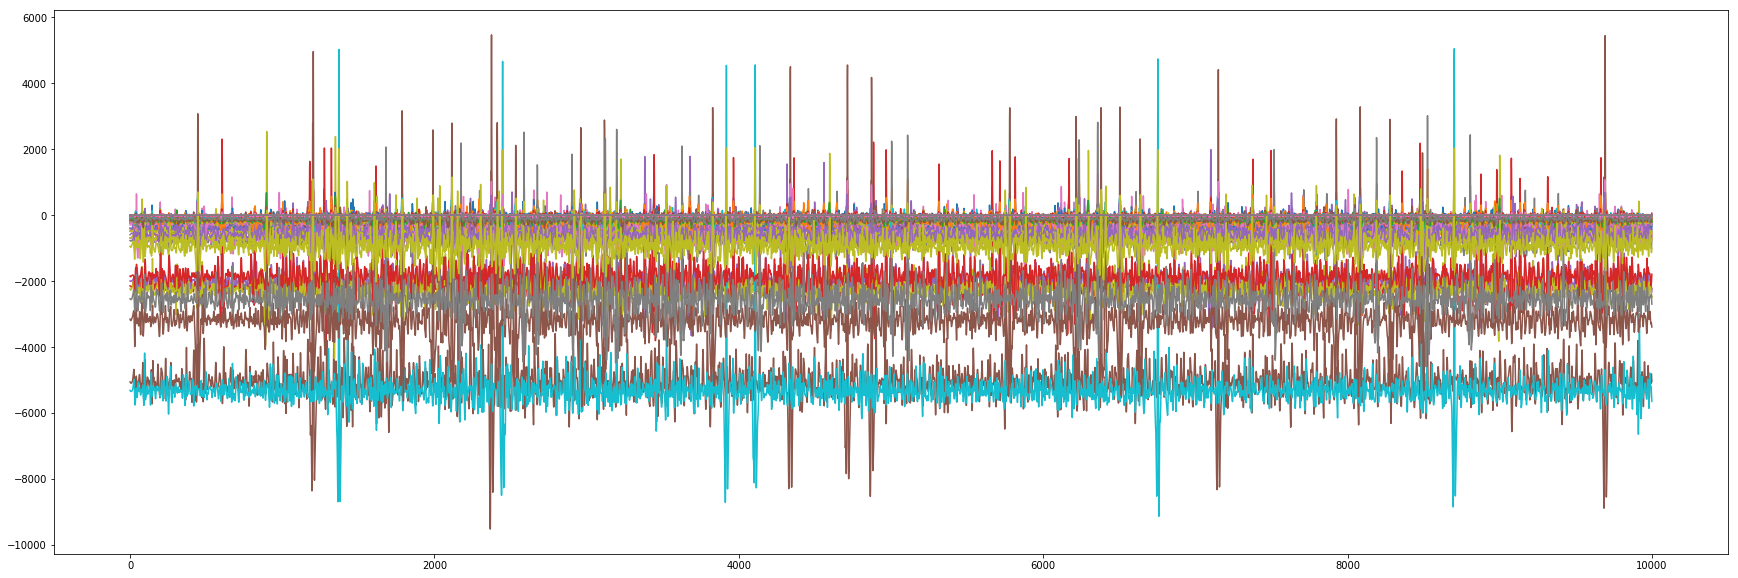

In [19]:
o1 = mp.compute_objective()

fig, ax = plt.subplots()
vis_o = o1[:, 0:10000]
ax.plot(vis_o.T)
ax.plot(vis_o.T * 0)
fig.set_size_inches(30, 10)
plt.show()

# Let's Run Deconvolution for a Fixed # of Iterations

In [31]:
deconvd_sp = mp.run(max_iter=20)
deconvd_sp[:, 0] += 25

Iteration 1 Found 1933 spikes with Max Obj 6003.41108296.
Iteration 2 Found 1802 spikes with Max Obj 5214.38283739.
Iteration 3 Found 1730 spikes with Max Obj 2754.29521919.
Iteration 4 Found 1721 spikes with Max Obj 1983.17167191.
Iteration 5 Found 1696 spikes with Max Obj 1983.17167191.
Iteration 6 Found 1657 spikes with Max Obj 1983.17167191.
Iteration 7 Found 1659 spikes with Max Obj 1983.17167191.
Iteration 8 Found 1614 spikes with Max Obj 1983.17167191.
Iteration 9 Found 1592 spikes with Max Obj 1983.20799669.
Iteration 10 Found 1605 spikes with Max Obj 1983.20799669.
Iteration 11 Found 1568 spikes with Max Obj 1983.20799669.
Iteration 12 Found 1591 spikes with Max Obj 1981.44053826.
Iteration 13 Found 1576 spikes with Max Obj 1981.64137193.
Iteration 14 Found 1556 spikes with Max Obj 1981.43943785.
Iteration 15 Found 1574 spikes with Max Obj 1981.43943785.
Iteration 16 Found 1574 spikes with Max Obj 1981.43943785.
Iteration 17 Found 1571 spikes with Max Obj 1981.43943785.
Iterat

In [32]:
gold_sp_trunc = gold_sp[gold_sp[:, 0] < TOT_TIME, :]
print "Ground Truth Spikes #:\t\t{}".format(gold_sp[gold_sp[:, 0] < 20000 * 10, :].shape[0])
print "Recovered Truth Spikes #:\t{}".format(deconvd_sp.shape[0])

Ground Truth Spikes #:		7139
Recovered Truth Spikes #:	32718


# Let's visualize a Temporal Cunk of the Objective Matrix Ater Deconv

/home/hooshmand/Documents/github/yassenv/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


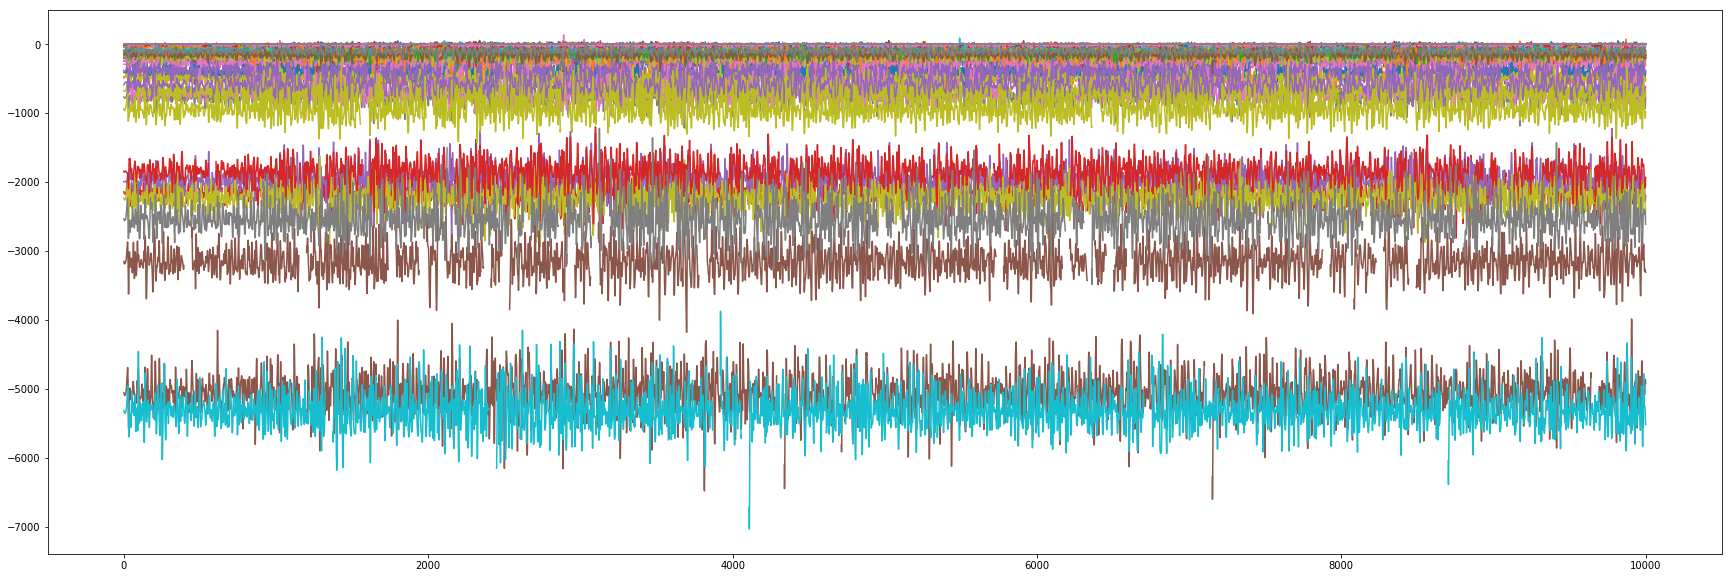

In [70]:
o1 = mp.compute_objective()

fig, ax = plt.subplots()
vis_o = o1[:, 0:10000]
ax.plot(vis_o.T)
ax.plot(vis_o.T * 0)
fig.set_size_inches(30, 10)
plt.show()

In [33]:
geom_m = parse(os.path.join(base_dir, geom), 49)
m_c = main_channels(mwc_temps)[:, -1]
temps = mwc_temps
snrs = compute_snr(temps)

# Summary of Performance

In [51]:
print 'unit\t#sp\t%TP\t%FP\tSNR\tmain ch'
gold_sp_trunc = gold_sp[gold_sp[:, 0] < TOT_TIME, :]
diffs = []
#for unit in np.unique(gold_sp_trunc[:, 1]):
TP = []
FP = []
for unit in np.argsort(snrs):
    gsp = gold_sp_trunc[gold_sp_trunc[:, 1] == unit, 0]
    sp = np.sort(deconvd_sp[deconvd_sp[:, 1] == unit, 0])
    n_spikes = len(gsp)
    n_recovered = len(sp)
    n_matches = count_matches(gsp, sp)
    n_misses = n_recovered - n_matches
    #
    tp = (n_matches * 1.) / n_spikes
    fp = (n_misses * 1.) / n_recovered
    diffs.append(n_spikes - n_recovered)
    TP.append(tp)
    FP.append(fp)
    print '{0}\t{1}\t{2:.2f}\t{3:.2f}\t{4:.1f}\t{5}'.format(
        unit, n_spikes, tp, fp, snrs[unit], m_c[unit])


unit	#sp	%TP	%FP	SNR	main ch
22	435	0.34	0.87	0.5	45
46	161	0.56	0.91	1.4	48
32	227	0.52	0.91	1.6	41
40	76	0.80	0.99	1.6	46
43	54	0.91	0.99	1.8	48
21	106	0.84	0.97	1.8	21
20	126	0.66	0.96	1.9	39
11	32	0.62	0.98	3.0	45
2	42	0.67	0.88	3.5	48
29	309	0.91	0.82	4.0	44
34	15	0.80	0.97	4.5	42
12	52	0.94	0.83	4.9	33
47	44	0.86	0.73	4.9	42
45	175	0.99	0.22	5.2	43
14	100	0.98	0.80	5.3	15
35	101	0.94	0.61	5.4	9
41	133	0.93	0.74	5.7	26
39	167	0.99	0.44	5.7	18
42	233	0.98	0.13	5.8	28
13	67	0.99	0.82	5.9	37
37	106	0.97	0.66	6.1	24
6	72	0.97	0.95	6.1	22
15	93	0.98	0.55	6.2	4
16	38	0.97	0.67	6.7	42
38	152	1.00	0.62	6.8	13
30	211	0.99	0.52	6.8	29
0	58	1.00	0.12	6.9	45
31	140	0.99	0.65	6.9	34
24	313	0.94	0.29	7.0	19
33	125	0.99	0.40	7.3	12
10	86	0.95	0.93	7.4	9
1	71	0.97	0.44	7.5	31
44	162	0.96	0.09	7.9	0
19	125	0.98	0.40	8.2	21
36	294	0.99	0.07	8.4	5
17	45	0.87	0.22	8.5	10
48	47	0.94	0.15	9.7	10
28	394	0.97	0.01	13.4	39
18	51	1.00	0.04	15.7	47
23	322	1.00	0.01	16.9	16
7	132	0.98	0.00	17.8	48
26	333	1.0

(0, 4)

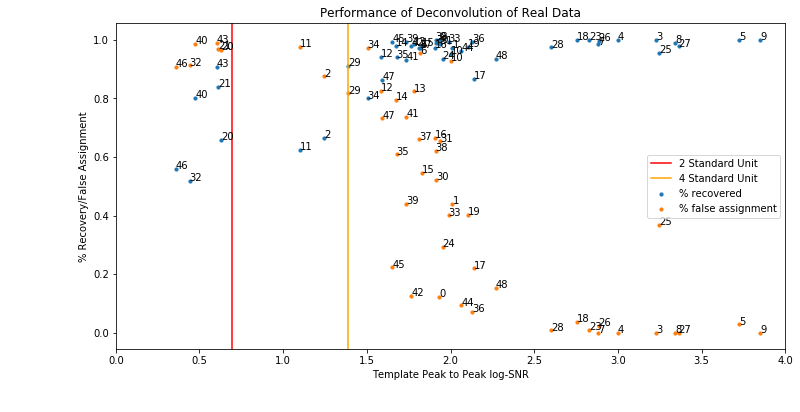

In [77]:
log_snrs = np.log(snrs)

plt.scatter(np.sort(log_snrs), TP, s=10)
plt.scatter(np.sort(log_snrs), FP, s=10)
for i, u in enumerate(snr_ord_unit_list):
    plt.gca().annotate(u, (log_snrs[u], TP[i]))
    plt.gca().annotate(u, (log_snrs[u], FP[i]))
plt.axvline(np.log(2), color='r')
plt.axvline(np.log(4), color='orange')
plt.legend(['2 Standard Unit', '4 Standard Unit', '% recovered', '% false assignment'])
plt.xlabel('Template Peak to Peak log-SNR')
plt.ylabel('% Recovery/False Assignment')
plt.title('Performance of Deconvolution of Real Data')
plt.gcf().set_size_inches(12, 6)
plt.xlim(0, 4)
#plt.savefig('Deconv_Performance.pdf')

In [78]:
all_units = np.unique(gold_sp_trunc[:, 1])
# Units that have a large difference in recovered vs. original
bad_units = np.where(np.abs(diffs) > 5)[0]

# Visualize Spatial Traces of Templates and Recovered Mean Wave Forms

100%|██████████| 2/2 [00:00<00:00,  3.92it/s]


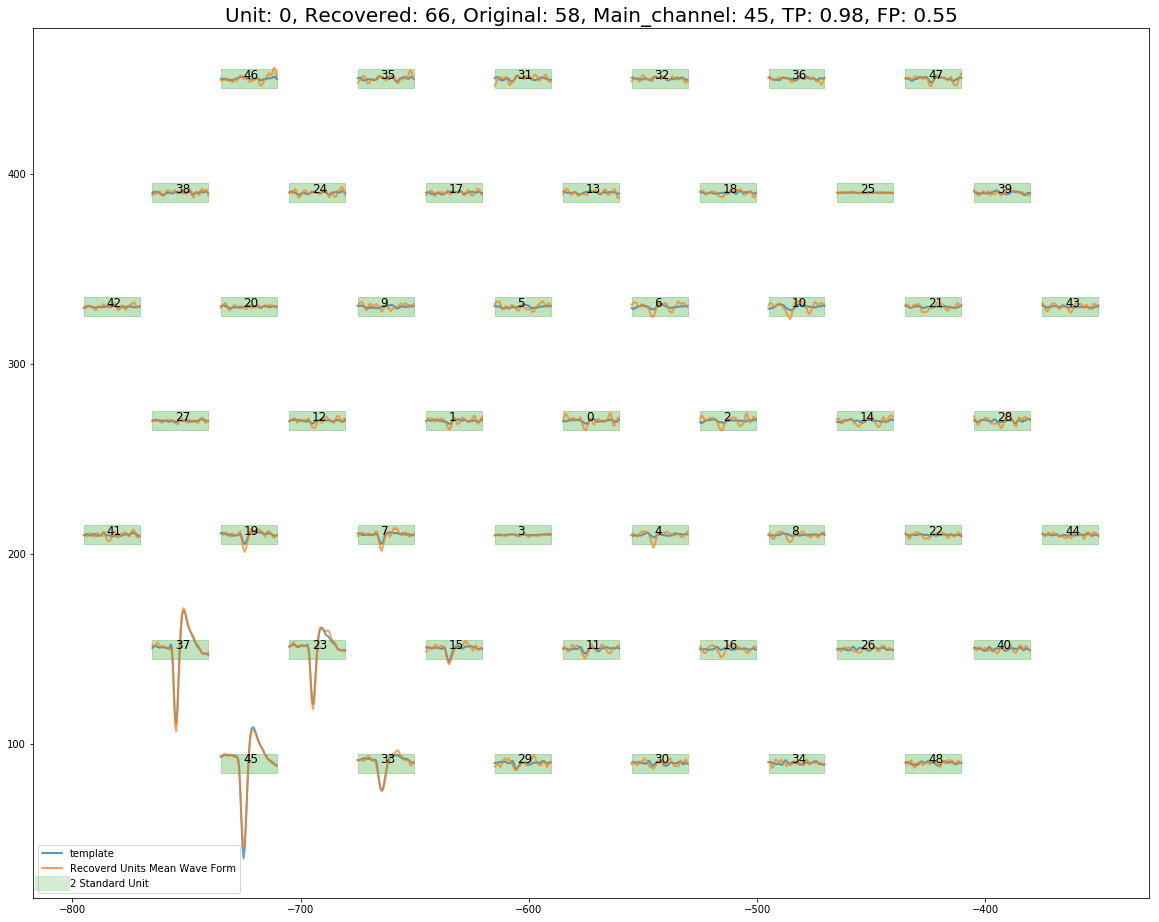

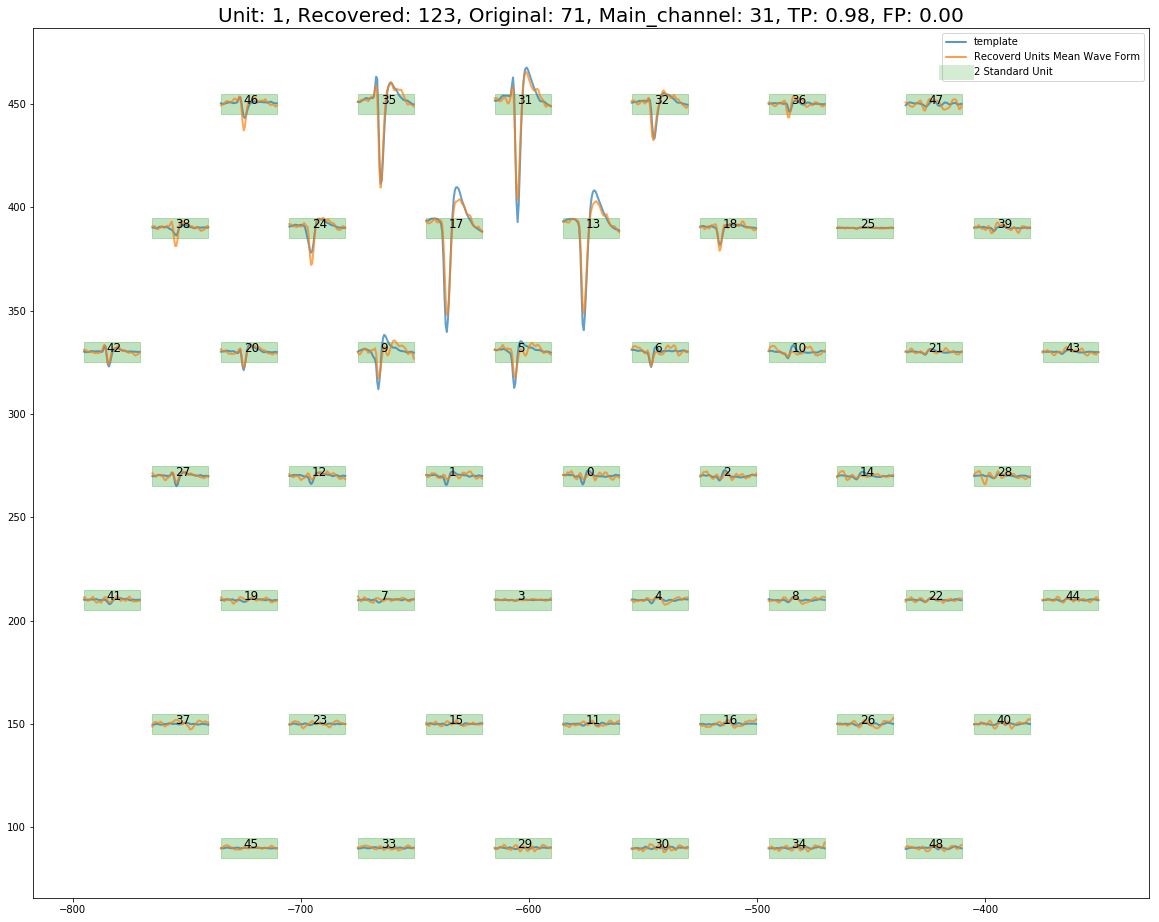

In [87]:
ord_tp = np.zeros(49)
ord_fp = np.zeros(49)
for i in range(49):
    ord_tp[i] = TP[snr_ord_unit_list[i]]
    ord_fp[i] = FP[snr_ord_unit_list[i]]

gold_sp_trunc = gold_sp[gold_sp[:, 0] < TOT_TIME, :]
for unit in tqdm(all_units):
    fig, ax = plt.subplots()
    sp = deconvd_sp[deconvd_sp[:, 1] == unit, 0]
    sp = sp[:, np.newaxis] + np.arange(-25, 25, 1)
    plot_spatial(geom_m, temps[:, :, unit], ax, color='C0', scale=10., squeeze=2.)
    plot_spatial(geom_m, np.mean(data[:, :][sp], axis=0), ax, color='C1', scale=10., squeeze=2.)
    plot_spatial_fill(geom_m, temps[:, :, unit] * 0, ax, color='C2', scale=10., squeeze=2.)
    plot_chan_numbers(geom_m, ax)
    # Add legends.
    legend_elements = [Line2D([0], [0], color='C0', label='template'),
                       Line2D([0], [0], color='C1', label='Recoverd Units Mean Wave Form'),
                       Line2D([0], [0], lw=15, color='C2', alpha=0.2, label='2 Standard Unit')]
    ax.legend(handles=legend_elements)
    ax.set_title('Unit: {0}, Recovered: {1}, Original: {2}, Main_channel: {3}, TP: {4:.2f}, FP: {5:.2f}'.format(
        unit, len(sp), np.sum(gold_sp_trunc[:, 1] == unit), m_c[unit], ord_tp[unit], ord_fp[unit]), fontsize=20)
    fig.set_size_inches(20, 16)
    #plt.savefig('deconv_templates_easy_unit{}.pdf'.format(unit))